### 3. Análise de Satisfação do Cliente

**a. Avaliações de Produtos:**  
Analisar a distribuição das avaliações dos produtos e identificar os produtos com as melhores e piores avaliações.


### Configuração do Ambiente e Carga de Dados

A primeira etapa consiste na preparação do ambiente de análise. O código a seguir importa as bibliotecas necessárias — **PySpark** para manipulação de dados e **Matplotlib/Seaborn** para visualização — e carrega os datasets do Unity Catalog para DataFrames Spark.

In [0]:
# Importa funções essenciais do PySpark
from pyspark.sql.functions import col, to_timestamp, datediff, avg, when, round, sum as _sum, countDistinct, year, month, quarter, count
from pyspark.sql import functions as F

# Importa as bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

# Carrega cada tabela diretamente do seu catálogo e schema
customers_df = spark.table("workspace.default.olist_customers")
orders_df = spark.table("workspace.default.olist_orders")
order_items_df = spark.table("workspace.default.olist_order_items")
payments_df = spark.table("workspace.default.olist_order_payments")
reviews_df = spark.table("workspace.default.olist_order_reviews")
products_df = spark.table("workspace.default.olist_products")
sellers_df = spark.table("workspace.default.olist_sellers")
geolocation_df = spark.table("workspace.default.olist_geolocation")

print("Todos os datasets foram carregados com sucesso a partir do Unity Catalog.")

Todos os datasets foram carregados com sucesso a partir do Unity Catalog.


### Etapa 2: Preparação dos Dados para Análise de Avaliações

**Objetivo:** Construir o *DataFrame* principal para a análise de satisfação do cliente.

Trata-se de um processo de **ETL** que conecta informações de diferentes tabelas para associar diretamente a **nota da avaliação** ao **produto avaliado**.

#### Passos do Processo:

1. **Unir `reviews_df` com `order_items_df`:**  
   Conecta cada avaliação (`review_score`) ao item de pedido correspondente, vinculando a experiência do cliente ao produto entregue.

2. **Unir o resultado com `products_df`:**  
   Associa cada item de pedido à sua **categoria de produto**, permitindo análises por segmento.

---

 O *DataFrame* final será chamado `avaliacoes_produtos_df`, contendo:

- A nota de avaliação (`review_score`)
- O identificador do produto (`product_id`)
- A categoria do produto (`product_category_name`)

In [0]:
# Etapa 2: Preparação dos Dados de Avaliações

# 1. Consolidação (Joins)
# Une as tabelas para conectar a nota da avaliação (review_score) à sua respectiva categoria de produto.
avaliacoes_produtos_df = reviews_df.join(
    order_items_df, on="order_id", how="inner"
).join(
    products_df, on="product_id", how="inner"
)

# 2. Projeção (Seleção de Colunas)
# Seleciona apenas as colunas necessárias para a análise, renomeando para maior clareza.
avaliacoes_produtos_df = avaliacoes_produtos_df.select(
    "order_id",
    "product_id",
    "review_score",
    F.col("product_category_name").alias("categoria_produto")
).filter(
    F.col("categoria_produto").isNotNull() # Remove registros sem categoria para garantir a qualidade
)

# Exibe uma mensagem de sucesso e uma amostra do DataFrame final.
print("DataFrame de avaliações e produtos criado com sucesso.")
display(avaliacoes_produtos_df)

DataFrame de avaliações e produtos criado com sucesso.


order_id,product_id,review_score,categoria_produto
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,5,cool_stuff
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,4,pet_shop
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5,moveis_decoracao
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,4,perfumaria
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,5,ferramentas_jardim
00048cc3ae777c65dbb7d2a0634bc1ea,ef92defde845ab8450f9d70c526ef70f,4,utilidades_domesticas
00054e8431b9d7675808bcb819fb4a32,8d4f2bb7e93e6710a28f34fa83ee7d28,4,telefonia
000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,5,ferramentas_jardim
0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,1,beleza_saude
0005f50442cb953dcd1d21e1fb923495,4535b0e1091c278dfd193e5a1d63b39f,4,livros_tecnicos


### Etapa 3: Análise da Distribuição Geral das Avaliações

A primeira etapa da análise de satisfação é entender o panorama geral do feedback dos clientes. O objetivo é quantificar como as notas de avaliação (de 1 a 5) se distribuem em todo o conjunto de pedidos.

Esta análise responde à pergunta fundamental: **"De forma geral, os clientes estão satisfeitos? Qual é a nota mais comum?"**

O resultado revelará se a percepção dos clientes é predominantemente positiva (concentrada em notas 4 e 5) ou negativa, estabelecendo uma linha de base para análises mais aprofundadas por categoria ou produto.

A célula a seguir realiza essa agregação e exibe a tabela de resultados.
```


In [0]:
# Etapa 3: Distribuição Geral das Notas de Avaliação

# 1. Agregação por Nota 
# Agrupa o DataFrame por nota de avaliação (review_score) e conta a frequência de cada uma.
distribuicao_avaliacoes = avaliacoes_produtos_df.groupBy("review_score").agg(
    F.count("order_id").alias("total_avaliacoes")
).orderBy("review_score")

# 2. Verificação 
# Exibe a tabela com a contagem de avaliações para cada nota.
print("Distribuição Geral das Notas de Avaliação:")
display(distribuicao_avaliacoes)

Distribuição Geral das Notas de Avaliação:


review_score,total_avaliacoes
1,13945
2,3811
3,9322
4,21014
5,62682


### Etapa 4: Visualização da Distribuição Geral das Avaliações

Com os dados agregados na etapa anterior, o próximo passo é traduzir a tabela de distribuição de notas em um gráfico de barras. A visualização permite uma interpretação imediata do sentimento geral dos clientes, algo que uma tabela por si só não consegue transmitir com tanto impacto.

O gráfico a seguir mostra a quantidade total de avaliações para cada nota (de 1 a 5). Para enriquecer a análise, cada barra é anotada com seu percentual correspondente, o que facilita a compreensão da proporção de clientes satisfeitos versus insatisfeitos.

Esta visualização nos permitirá identificar rapidamente se a experiência do cliente é majoritariamente positiva (com um pico em notas 4 e 5) ou se há pontos de atenção significativos.


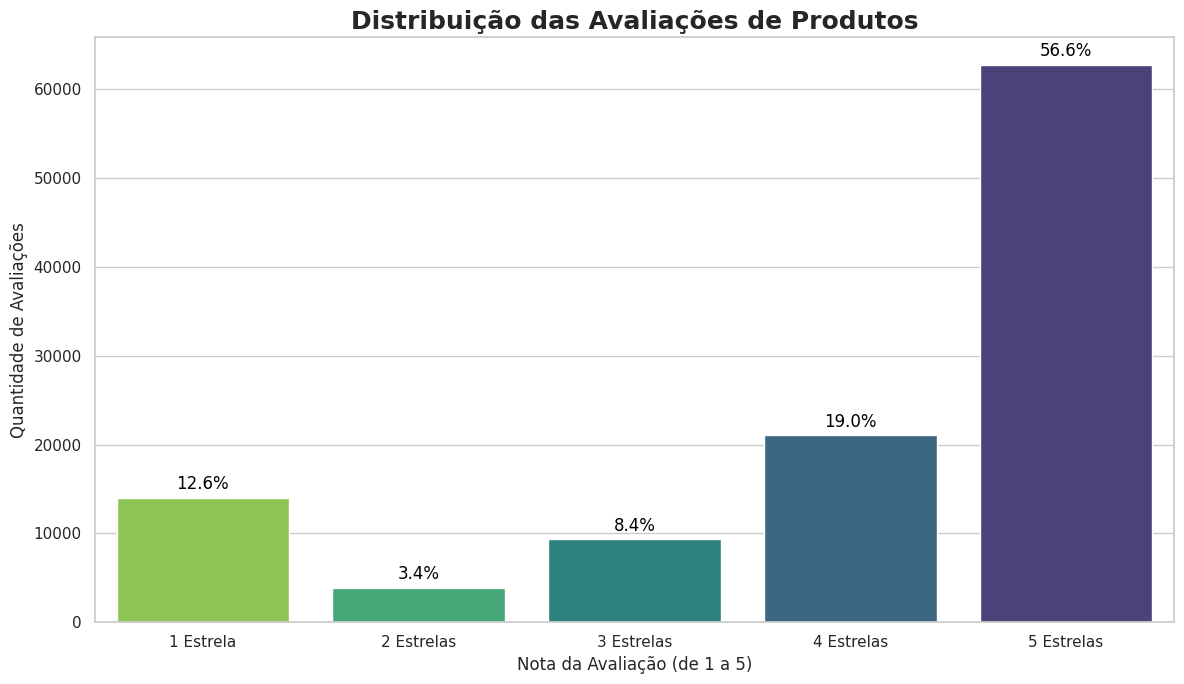

In [0]:
# Etapa 4: Visualização da Distribuição Geral das Avaliações

# 1. Preparação dos Dados para Plotagem
# Converte o resultado agregado do Spark para Pandas.
distribuicao_pd = distribuicao_avaliacoes.toPandas()

# Calcula o percentual de cada nota em relação ao total para usar nos rótulos.
total_geral = distribuicao_pd['total_avaliacoes'].sum()
distribuicao_pd['percentual'] = (distribuicao_pd['total_avaliacoes'] / total_geral) * 100

# 2. Criação do Gráfico de Barras
# Configura a figura e o tema do gráfico.
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Cria o gráfico de barras que mostra a contagem de cada nota de avaliação.
barplot = sns.barplot(
    data=distribuicao_pd,
    x="review_score",
    y="total_avaliacoes",
    palette="viridis_r" 
)

# 3. Adição de Contexto e Rótulos
# Adiciona os rótulos de percentual no topo de cada barra para clareza.
for index, row in distribuicao_pd.iterrows():
    barplot.text(row.name, row.total_avaliacoes + 1000, f"{row.percentual:.1f}%",
                 color='black', ha="center", fontsize=12)

# Define os títulos e os nomes dos eixos.
plt.title("Distribuição das Avaliações de Produtos", fontsize=18, weight='bold')
plt.xlabel("Nota da Avaliação (de 1 a 5)", fontsize=12)
plt.ylabel("Quantidade de Avaliações", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1 Estrela', '2 Estrelas', '3 Estrelas', '4 Estrelas', '5 Estrelas'])

# Exibe o gráfico.
plt.tight_layout()
plt.show()

### Etapa 5: Ranking e Visualização da Satisfação por Categoria

Após a análise geral, o foco agora se aprofunda no desempenho por categoria de produto. O objetivo é identificar quais linhas de produto se destacam pela alta satisfação e quais representam pontos de atrito, fornecendo insights estratégicos para a gestão de portfólio.

A análise adota uma metodologia robusta para garantir a relevância dos resultados:

- **Agregação e Filtro**: A nota média é calculada para cada categoria, mas apenas aquelas com um volume mínimo de 100 avaliações são consideradas, garantindo a significância estatística.

- **Visualização Comparativa**: Para destacar os extremos, os resultados são apresentados em dois gráficos de barras lado a lado, um para as 10 melhores e outro para as 10 piores categorias. A utilização de uma escala de nota idêntica em ambos os gráficos permite uma comparação visual direta e justa da performance.

Esta abordagem permite identificar rapidamente tanto os *"campeões de satisfação"* quanto as categorias que podem exigir uma revisão de qualidade ou estratégia.


Categorias com Melhores Avaliações (com no mínimo 100 avaliações):


categoria_produto,nota_media_categoria,total_avaliacoes_categoria
livros_interesse_geral,4.45,549
livros_tecnicos,4.37,266
alimentos_bebidas,4.32,279
malas_acessorios,4.32,1088
fashion_calcados,4.23,261
alimentos,4.22,495
papelaria,4.19,2507
pet_shop,4.19,1939
pcs,4.18,200
eletrodomesticos,4.17,806



Categorias com Piores Avaliações (com no mínimo 100 avaliações):


categoria_produto,nota_media_categoria,total_avaliacoes_categoria
moveis_escritorio,3.49,1687
fashion_roupa_masculina,3.64,131
telefonia_fixa,3.68,262
casa_conforto,3.83,435
audio,3.83,361
construcao_ferramentas_seguranca,3.84,193
moveis_sala,3.9,502
cama_mesa_banho,3.9,11137
moveis_decoracao,3.9,8331
informatica_acessorios,3.93,7849


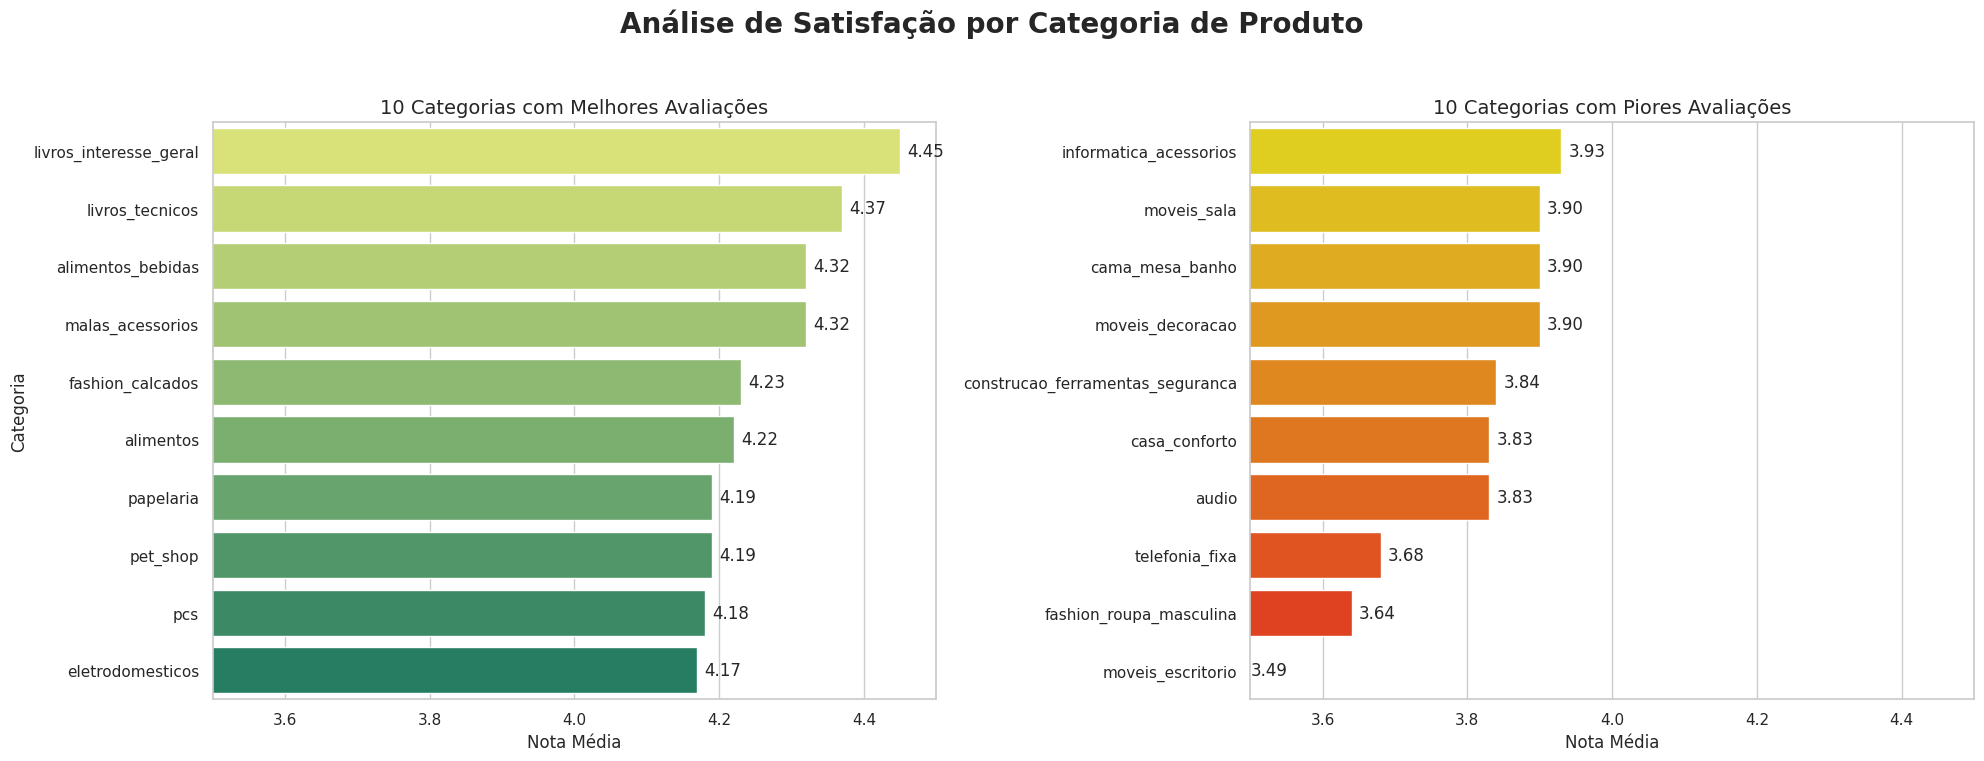

In [0]:
# Etapa 5: Ranking e Visualização da Satisfação por Categoria

# 1. Agregação e Filtro de Relevância por Categoria
# Agrupa por categoria para calcular a nota média e o total de avaliações.
# Filtra por um volume mínimo de 100 avaliações para garantir relevância estatística.
categorias_avaliadas = avaliacoes_produtos_df.filter(F.col("categoria_produto").isNotNull()) \
    .groupBy("categoria_produto") \
    .agg(
        F.round(F.avg("review_score"), 2).alias("nota_media_categoria"),
        F.count("review_score").alias("total_avaliacoes_categoria")
    ).filter(F.col("total_avaliacoes_categoria") >= 100)

# 2. Criação dos Rankings (Melhores e Piores)
# Ordena os resultados para encontrar as categorias com as maiores notas médias.
melhores_categorias = categorias_avaliadas.orderBy(F.col("nota_media_categoria").desc())
# Inverte a ordenação para encontrar as categorias com as piores notas médias.
piores_categorias = categorias_avaliadas.orderBy(F.col("nota_media_categoria").asc())

# Exibe as tabelas com os rankings.
print("Categorias com Melhores Avaliações (com no mínimo 100 avaliações):")
display(melhores_categorias.limit(10))
print("\nCategorias com Piores Avaliações (com no mínimo 100 avaliações):")
display(piores_categorias.limit(10))


# 3. Preparação dos Dados para Visualização
# Converte os 10 primeiros de cada ranking para Pandas.
melhores_cat_pd = melhores_categorias.limit(10).toPandas()
# Para o gráfico das piores, reordena do maior para o menor para um visual mais agradável.
piores_cat_pd = piores_categorias.limit(10).toPandas().sort_values("nota_media_categoria", ascending=False)


# 4. Criação dos Gráficos Lado a Lado
# Configura a figura para ter dois subplots.
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Aumentei a largura para os rótulos
fig.suptitle('Análise de Satisfação por Categoria de Produto', fontsize=20, weight='bold')
sns.set_theme(style="whitegrid")

# Gráfico da Esquerda: Melhores Categorias
sns.barplot(ax=axes[0], data=melhores_cat_pd, y='categoria_produto', x='nota_media_categoria', palette='summer_r')
axes[0].set_title('10 Categorias com Melhores Avaliações', fontsize=14)
axes[0].set_xlim(3.5, 4.5) # Define um limite fixo no eixo X para comparação justa.
axes[0].set_xlabel('Nota Média')
axes[0].set_ylabel('Categoria')

# Adiciona os valores no final de cada barra (Gráfico da Esquerda)
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(x=width + 0.01,
                 y=p.get_y() + p.get_height() / 2,
                 s=f'{width:.2f}',
                 va='center')

# Gráfico da Direita: Piores Categorias
sns.barplot(ax=axes[1], data=piores_cat_pd, y='categoria_produto', x='nota_media_categoria', palette='autumn_r')
axes[1].set_title('10 Categorias com Piores Avaliações', fontsize=14)
axes[1].set_xlim(3.5, 4.5) # Usa o MESMO limite no eixo X.
axes[1].set_xlabel('Nota Média')
axes[1].set_ylabel('') # Remove o rótulo do eixo Y para um visual mais limpo.

# Adiciona os valores no final de cada barra (Gráfico da Direita)
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(x=width + 0.01,
                 y=p.get_y() + p.get_height() / 2,
                 s=f'{width:.2f}',
                 va='center')


# Ajusta o layout e exibe a figura.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para o super-título caber
plt.show()

### Etapa 6. Visualização do Ranking Completo de Satisfação por Categoria

Para obter uma visão estratégica do portfólio de produtos, esta etapa apresenta um ranking unificado de todas as categorias relevantes. O objetivo é criar um mapa visual completo da performance, permitindo uma comparação direta entre todas as linhas de produto.

O gráfico a seguir ordena as categorias da melhor para a pior nota média. Para destacar os extremos de desempenho, um sistema de cores é aplicado:

- **Destaques Positivos (Verde):** As 5 categorias com as maiores notas médias.
- **Pontos de Atenção (Vermelho):** As 5 categorias com as piores notas médias.
- **Desempenho Intermediário (Cinza):** Todas as outras categorias são mantidas em uma cor neutra, servindo como uma base de comparação e contextualizando os extremos.

Dessa forma, a visualização não apenas aponta os sucessos e os desafios de forma clara, mas também mostra a performance de cada categoria em relação ao todo, oferecendo uma perspectiva rica para a tomada de decisão.


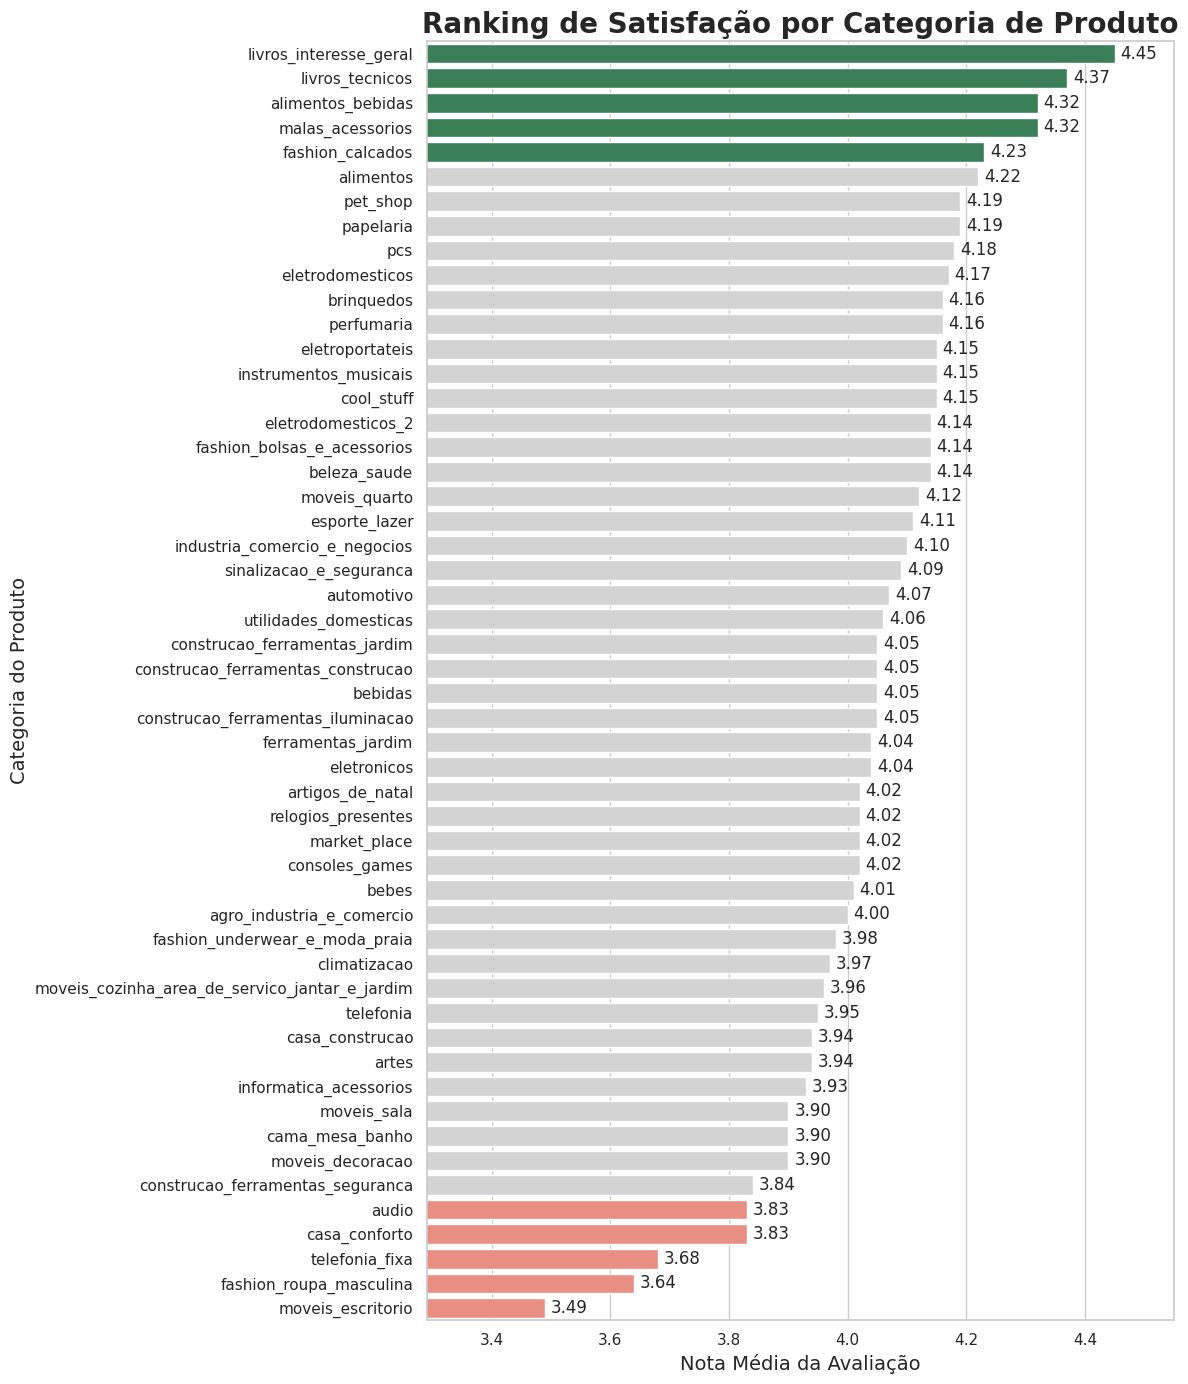

In [0]:
# Etapa 6: Visualização do Ranking de Satisfação por Categoria

# 1. Preparação dos Dados para Plotagem
# Converte o DataFrame completo de categorias avaliadas para Pandas, ordenado pela nota.
ranked_cat_pd = categorias_avaliadas.orderBy(F.col("nota_media_categoria").desc()).toPandas()

# 2. Lógica de Coloração para Destaque 
# Cria uma lista de cores para destacar as melhores e piores categorias.
colors = ['lightgray'] * len(ranked_cat_pd) # Começa com todas cinzas
num_destaques = 5 # Define quantas categorias destacar em cada ponta

for i in range(min(num_destaques, len(ranked_cat_pd))):
    colors[i] = 'seagreen'  # As 5 melhores em verde
    colors[-1 - i] = 'salmon' # As 5 piores em vermelho

# 3. Criação do Gráfico de Barras
# Configura a figura (mais alta para caber todas as categorias).
plt.figure(figsize=(12, 14))
sns.set_theme(style="whitegrid")

# Cria o gráfico de barras horizontais.
ax = sns.barplot(
    data=ranked_cat_pd,
    x='nota_media_categoria',
    y='categoria_produto',
    palette=colors # Aplica a paleta de cores customizada
)

# 4. Adição de Contexto e Rótulos
# Define os títulos e os nomes dos eixos.
plt.title('Ranking de Satisfação por Categoria de Produto', fontsize=20, weight='bold')
plt.xlabel('Nota Média da Avaliação', fontsize=14)
plt.ylabel('Categoria do Produto', fontsize=14)
# Define um limite no eixo X para facilitar a comparação visual entre as barras.
plt.xlim(
    left=max(0, ranked_cat_pd['nota_media_categoria'].min() - 0.2), 
    right=ranked_cat_pd['nota_media_categoria'].max() + 0.1
)

# Adiciona os valores exatos no final de cada barra.
for p in ax.patches:
    width = p.get_width()
    plt.text(x=width + 0.01, 
             y=p.get_y() + p.get_height() / 2, 
             s=f'{width:.2f}', 
             va='center')

# Ajusta o layout e exibe o gráfico.
plt.tight_layout()
plt.show()

### Conclusão da Análise de Satisfação do Cliente

A análise das avaliações fornecidas pelos clientes revelou padrões claros sobre a percepção de qualidade dos produtos e categorias. Os resultados indicam um cenário geral positivo, mas com pontos de atenção significativos em segmentos específicos do portfólio.

**As principais conclusões são:**

- **Satisfação Geral Altamente Positiva:**  
  A distribuição das avaliações demonstra um forte viés positivo. Mais da metade dos clientes (56.6%) avalia sua experiência com a nota máxima (5 estrelas). Somando as notas 4 e 5, temos que mais de 75% das avaliações são positivas, indicando um alto nível de satisfação geral com os produtos e serviços.

- **Baixo Volume de Avaliações Críticas:**  
  As avaliações negativas são uma minoria. A nota mínima (1 estrela), embora seja a mais comum entre as notas negativas, representa apenas 12.6% do total. As notas 2 e 3 estrelas somadas não chegam a 12%, reforçando a percepção de que a insatisfação severa não é um problema generalizado.

- **Desempenho Excelente em Nichos Específicos:**  
  A análise por categoria revela "campeões de satisfação" claros. Categorias como `livros_interesse_geral` (nota média 4.45), `livros_tecnicos` (4.37) e `alimentos_bebidas` (4.32) se destacam com as maiores médias de avaliação, indicando uma forte adequação entre o produto oferecido e a expectativa do cliente nesses segmentos.

- **Pontos de Atenção em Categorias de Grande Volume:**  
  É notável que algumas das categorias com maior volume de vendas, como `cama_mesa_banho` e `moveis_decoracao`, apresentam notas médias apenas intermediárias (3.90). Em contrapartida, a categoria `moveis_escritorio` se destaca negativamente com a pior avaliação média (3.49) entre todas as categorias com volume relevante, sinalizando um ponto crítico que merece investigação aprofundada.
